In [1]:
import argparse
from datetime import datetime
import os
import pandas as pd

from utils import seed_everything, get_device, check_max_len, clean_gpu
from utils_config import get_model_config
from trainer import Trainer
from utils import prepare_datasets

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1
device = 0
target = 'mirna'
experiment_name = 'jupyter'
verbose=True
kmer=1

In [3]:
max_len = 1024
batch_size=32
d_model = 64
n_layer = 4
rc = False
is_trained = True
pooling_mode_target = 'mean'
is_convblock=False
is_cross_attention=True
rna_model = 'rnabert'

is_pretrained= False

In [4]:
model_name = 'tthymba'
load_pretrain_name='both__rnabert'


In [5]:
trainer = Trainer(
    seed=seed,
    device=device,
    experiment_name=experiment_name,
    verbose=verbose,
)

INFO:utils:Seeds set to 1.
✅ Logging setup complete.


In [6]:
max_len = check_max_len(max_len, model_name)
# df = pd.read_pickle(f'./data/df_final.pkl')
df = pd.read_pickle(f'./data/df_train_final.pkl')
df_test = pd.read_pickle(f'./data/df_test_final.pkl')

INFO:utils:Max length set to 1022 for model tthymba


In [7]:
df['length'] = df['circRNA'].apply(len)
df_test['length'] = df_test['circRNA'].apply(len)
# df = df[df['length'] <= max_len]
# df_test = df_test[df_test['length'] <= max_len]
# df['sum_sites'] = df['sites'].apply(sum)

In [8]:
train_dataset, valid_dataset, test_dataset, extra_dataset = prepare_datasets(
        df=df, 
        df_test=df_test,
        max_len=max_len + 2,  # 2 for special tokens (CLS and EOS)
        target=target, 
        seed=seed,
        kmer=1,
        # df_extra=df_test,
    )
trainer.set_dataloader(train_dataset, part=0, batch_size=batch_size)
trainer.set_dataloader(valid_dataset, part=1, batch_size=batch_size)
trainer.set_dataloader(test_dataset, part=2, batch_size=batch_size)

# Step 4. Configure Model
print('[Step 4] Configuring Model for training')
config = get_model_config(
    model_name=model_name,
    d_model=d_model,
    n_layer=n_layer,
    verbose=verbose,
    rc=rc,
    vocab_size=train_dataset.vocab_size
)

[Step 4] Configuring Model for training
- Model: tthymba
- d_model: 64
- n_layer: 4


In [9]:
trainer.define_model(
    config=config,
    model_name=model_name,
    pretrain=is_pretrained,
    pooling_mode_target=pooling_mode_target,
    is_convblock=is_convblock,
    is_cross_attention=is_cross_attention,
)

Model 'tthymba' initialized. Pretraining mode: False


In [10]:
trainer.set_pretrained_target(target=target, rna_model=rna_model)

Target model for mirna set with projection dimension 120


Target model for mirna set with projection dimension 120


In [11]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[ 2.1171, -0.8047, -0.4326,  ..., -0.1581,  0.7061,  0.7860],
        [ 1.2903,  0.4788,  0.7869,  ..., -0.7526,  0.3738,  1.8700],
        [-0.5223, -1.0558,  0.9727,  ..., -0.6165,  0.0953,  1.0375],
        ...,
        [ 0.5804,  0.9359, -0.6342,  ..., -1.2782,  0.4070,  1.6779],
        [ 0.4724, -0.4864, -0.2338,  ..., -1.2388,  0.8289,  2.7504],
        [ 1.5207, -1.5208,  0.2005,  ...,  0.9903,  0.7732,  2.1494]],
       device='cuda:0', requires_grad=True)

In [12]:
trainer.load_model(pretrain=is_pretrained, load_pretrain_name=load_pretrain_name, verbose=True)

O Model state loaded successfully from ./saved_models/tthymba/both__rnabert/1/train/model.pth
X Warning: embedding file not found at ./saved_models/tthymba/both__rnabert/1/train/embedding.pth.
X Failed to load embedding from ./saved_models/tthymba/both__rnabert/1/train/embedding.pth. Skipping.
X Warning: backbone file not found at ./saved_models/tthymba/both__rnabert/1/train/backbone.pth.
X Failed to load backbone from ./saved_models/tthymba/both__rnabert/1/train/backbone.pth. Skipping.
X Warning: proj_target file not found at ./saved_models/tthymba/both__rnabert/1/train/proj_target.pth.
X Failed to load proj_target from ./saved_models/tthymba/both__rnabert/1/train/proj_target.pth. Skipping.
X Warning: convblock file not found at ./saved_models/tthymba/both__rnabert/1/train/convblock.pth.
X Failed to load convblock from ./saved_models/tthymba/both__rnabert/1/train/convblock.pth. Skipping.
X Warning: binding_head file not found at ./saved_models/tthymba/both__rnabert/1/train/binding_hea

In [13]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[ 0.9479, -0.7230, -0.3928,  ..., -0.3658,  1.6671,  0.6287],
        [ 1.2354,  0.4954,  0.7389,  ..., -0.5744,  0.6583,  1.9300],
        [-0.2753, -1.0501,  0.4967,  ..., -0.7571, -0.2303,  0.0544],
        ...,
        [ 0.5804,  0.9359, -0.6342,  ..., -1.2782,  0.4070,  1.6779],
        [ 0.4724, -0.4864, -0.2338,  ..., -1.2388,  0.8289,  2.7504],
        [ 1.5207, -1.5208,  0.2005,  ...,  0.9903,  0.7732,  2.1494]],
       device='cuda:0', requires_grad=True)

In [14]:
trainer.rc = False
trainer.task = 'both'
trainer.verbose = True

In [15]:
results = trainer.inference(data_loader=trainer.test_loader)

In [16]:
results.pop('lengths_sites')
df_results = pd.DataFrame(results)

trainer.evaluate(trainer.test_loader)

trainer.best_threshold_site

In [17]:
import torch
import pandas as pd

def flatten_result_dict_per_sample(result_dict, sequences=None):
    """
    Converts nested result dict to a per-sample DataFrame.
    
    Parameters:
        result_dict: dict with keys ['binding', 'sites', 'lengths']
        sequences: optional list of circRNA sequence strings
    """
    # Unpack
    binding_logits = result_dict['binding'][0]     # list of [2] tensors
    site_logits = result_dict['sites'][0]          # list of [L, 2] tensors
    lengths = result_dict['lengths'][0]            # list of [1] tensors

    data = []
    for i in range(len(binding_logits)):
        sample = {
            "sample_id": i,
            "binding_logits": binding_logits[i].detach().cpu().tolist(),
            "site_logits": site_logits[i].detach().cpu().tolist(),
            "length": int(lengths[i].item())
        }
        if sequences is not None:
            sample["circRNA"] = sequences[i]
        data.append(sample)

    return pd.DataFrame(data)


In [18]:
df_samples = flatten_result_dict_per_sample(results, sequences=df_test['circRNA'].values)

In [19]:
df_results = pd.merge(df_samples, df_test, on='circRNA', how='outer')

In [ ]:
df_ss = pd.read_pickle('./data/df_circ_ss.pkl')

In [26]:
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import RNA

def extract_positive_spans(binary_array, min_len=1, max_len=None):
    """
    1D binary array에서 연속된 1 구간 추출 (min_len 이상, max_len 이하)
    """
    spans = []
    start = None
    for i, val in enumerate(binary_array):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            span_len = i - start
            if span_len >= min_len and (max_len is None or span_len <= max_len):
                spans.append((start, i))
            start = None
    if start is not None:
        span_len = len(binary_array) - start
        if span_len >= min_len and (max_len is None or span_len <= max_len):
            spans.append((start, len(binary_array)))
    return spans
    
def predict_circRNA_structure_doubled(seq):
    doubled_seq = seq + seq
    fc = RNA.fold_compound(doubled_seq)
    structure, mfe = fc.mfe()
    return structure, mfe, doubled_seq

def get_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0.0


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def get_iou(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0.0


def linear_binding_site_plot_with_overlap(df, sample_idx=0, threshold=0.5, min_span_len=20):
    row = df.iloc[sample_idx]

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    overlap_mask = np.logical_and(pred_mask, true_mask)

    # --- IoU 계산 ---
    iou = get_iou(pred_mask, true_mask)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.set_xlim(0, len(probs))
    ax.set_ylim(0, 1.0)

    # Overlap zone
    for i in range(len(overlap_mask)):
        if overlap_mask[i]:
            ax.axvspan(i, i+1, color='limegreen', alpha=0.5, label='Overlap' if i == np.where(overlap_mask)[0][0] else "")

    # Predicted spans
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        ax.axvspan(start, end, color='skyblue', alpha=0.4, label="Predicted" if start == extract_positive_spans(preds_binary, min_span_len)[0][0] else "")

    # True spans
    for start, end in extract_positive_spans(sites, min_span_len):
        ax.axvspan(start, end, color='orange', alpha=0.3, label="True" if start == extract_positive_spans(sites, min_span_len)[0][0] else "")

    # --- Line plot 제거됨 ---
    ax.plot(probs, label="Predicted probability", color='black', linewidth=1)

    # plt.title(f"circRNA: {row['isoform_ID']} | miRNA: {row['miRNA_ID']} ")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    # plt.legend(loc="lower right")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return iou


def plot_sequence_coloring_from_df(df, sample_idx=0, threshold=0.5, min_span_len=20, row_width=80, fontsize=8, structure = None):
    row = df.iloc[sample_idx]

    # --- sequence ---
    if structure is not None:
        seq = structure
    else:
        seq = row["circRNA"]
    if isinstance(seq, list):
        seq = ''.join(seq)
    sequence = list(seq)

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites), len(sequence))
    probs = probs[:min_len]
    sites = sites[:min_len]
    sequence = sequence[:min_len]

    preds_binary = (probs >= threshold).astype(int)

    # --- Span-based mask ---
    pred_mask = np.zeros_like(preds_binary)
    for start, end in extract_positive_spans(preds_binary, min_span_len):
        pred_mask[start:end] = 1

    true_mask = np.zeros_like(sites)
    for start, end in extract_positive_spans(sites, min_span_len):
        true_mask[start:end] = 1

    # --- 시각화 ---
    length = len(sequence)
    n_rows = (length + row_width - 1) // row_width

    fig, ax = plt.subplots(figsize=(row_width * 0.1, n_rows * 0.5))
    ax.set_xlim(-0.5, row_width + 0.5)
    ax.set_ylim(-n_rows - 0.5, 1 + 0.5)
    ax.axis("off")

    def get_color(i):
        if true_mask[i] and pred_mask[i]:
            return "limegreen"
        elif true_mask[i]:
            return "orange"
        elif pred_mask[i]:
            return "skyblue"
        else:
            return None
            
    for i in range(length):
        row_idx = -(i // row_width)
        col = i % row_width
        base = sequence[i]
        color = get_color(i)
    
        if color:
            rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
            ax.add_patch(rect)
    
        ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', 
                fontsize=fontsize, family='monospace', clip_on=False)


    # for i in range(length):
    #     row_idx = -(i // row_width)
    #     col = i % row_width
    #     base = sequence[i]
    #     color = get_color(i)

    #     if color:
    #         rect = patches.Rectangle((col, row_idx), 1, 1, color=color, alpha=0.6)
    #         ax.add_patch(rect)

    #     ax.text(col + 0.5, row_idx + 0.5, base, ha='center', va='center', fontsize=fontsize, family='monospace')

    plt.tight_layout()
    plt.show()

df_ss = pd.read_pickle('./data/df_circ_ss.pkl')

circRNA: GCAGAGAUUGUCAAGAGGCUGAAUGCUAUCUGUGCACAAGUCAUUCCUUUCCUGUCCCAAGAGGGCAUCUCUGAUGUUUUUUAUCUGAACAUCGUCCACCUUGUUUCUUCUUCUGUGCAUUCUGUGAGCAUUGGACUCCUUGCUUCUGCCCUGAAGCCAGAUGGACCAUAAUCUGGAGGGAGGGGAGGAGCAGCACCAGCAACAAGUGGUGCAGGCUGUGGAACGGGCCAAGCAGGUGACCAUGGCAGAACUGAACGCCAUCAUUGGG
structure: ((((.((..(...((.((((...(((.......)))..)))).)).)..))))))(((((((.(((......(((((((.......)))))))(((((...(((((...................))))).)))))....(((((((.((((....((((((........))))))....)))).)))))))((((((........))))))..(((((((.((..((...))..))..)))))))..........))).)).)))))
circRNA ID: chr9|79612656,79615076,79627374|79612718,79615205,79627448|+
miRNA ID: hsa-miR-4691-5p


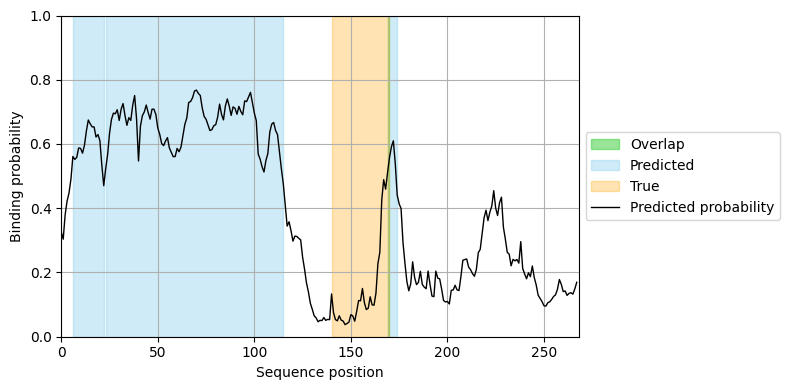

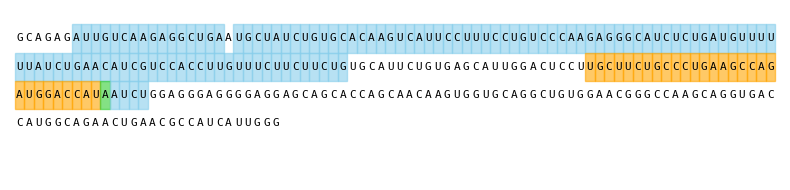

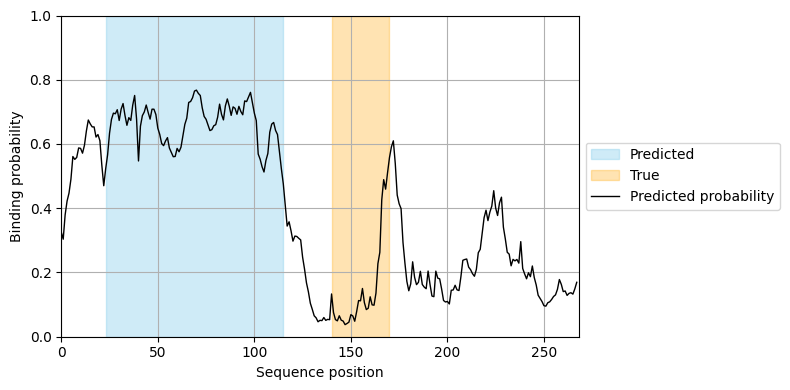

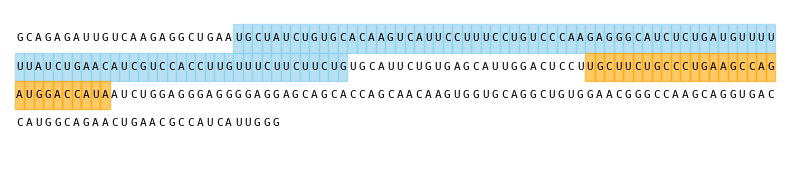

In [28]:
idx = 75638      
# idx = 83393                       
# idx = 62097   
# idx = 27364
# idx = 52018      
# idx = 83393                       
threshold=0.5

circrna_id = df_results['isoform_ID'].iloc[idx]
mirna_seq = df_results['miRNA'].iloc[idx]
mirna_id = df_results['miRNA_ID'].iloc[idx]
circrna_seq = df_results['circRNA'].iloc[idx]
isoform_id = df_results['isoform_ID'].iloc[idx]
try:
    structure = df_ss[df_ss['isoform_ID'] == isoform_id]['structure'].values[0]
except:
    structure = []
if len(structure) < 1:
    print('~~')
    structure, mfe, doubled_seq = predict_circRNA_structure_doubled(circrna_seq)
print(f'circRNA: {circrna_seq}')
print(f'structure: {structure}')
print(f'circRNA ID: {circrna_id}')
print(f'miRNA ID: {mirna_id}')



min_span_len = 1
threshold = 0.5
iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)

min_span_len = len(df_results['miRNA'].iloc[idx])

iou = linear_binding_site_plot_with_overlap(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len)
# plot_sequence_coloring_from_df(df_results, sample_idx=idx, threshold=threshold, min_span_len=min_span_len, structure=structure)

